In [9]:
from virtual_swap.vswap_pass import VirtualSwap
from qiskit import QuantumCircuit

# from qiskit.test import QiskitTestCase
from qiskit.transpiler import CouplingMap, PassManager
from qiskit.transpiler.passes import (
    Unroller,
    TrivialLayout,
    ApplyLayout,
    SabreLayout,
    CountOpsLongestPath,
)
from qiskit.transpiler.passes import OptimizeSwapBeforeMeasure
import numpy as np

from slam.utils.transpiler_pass.weyl_decompose import RootiSwapWeylDecomposition

# this code is buggy, see https://github.com/Qiskit/qiskit
# I can't use this version bc qiskit version missing DAGCircuit functionality

# build a toffoli
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)

# build a 2x2 square coupling map
coupling = CouplingMap.from_line(4)


# qc = QuantumCircuit(16)
# # generate network of random cnots
# for _ in range(20):
#     qc.cx(*np.random.choice(16, 2, replace=False))
# coupling = CouplingMap.from_grid(4, 4)

# medium sized circuit
qc = QuantumCircuit(8)
# add some toffolis and cxs
for _ in range(4):
    qc.ccx(*np.random.choice(8, 3, replace=False))
    qc.cx(*np.random.choice(8, 2, replace=False))
coupling = CouplingMap.from_grid(2, 4)

In [10]:
from qiskit import transpile

qc2 = transpile(qc, coupling_map=coupling, basis_gates=["cx", "u3"])
pm = PassManager([RootiSwapWeylDecomposition(), CountOpsLongestPath()])
qc3 = pm.run(qc2)
# qc3.draw(output='mpl')

# print(qc3.count_ops())
print(f"Gate count: {qc3.count_ops()['riswap']}")
# print(pm.property_set['count_ops_longest_path'])
# print(f"Depth: {qc3.depth()}")
print(
    f"Gate count critical path: {pm.property_set['count_ops_longest_path']['riswap']}"
)

Gate count: 104
Gate count critical path: 74


In [11]:
from virtual_swap.sqiswap_equiv import sel  # SessionEquivalenceLibrary

qc4 = transpile(
    qc, basis_gates=["u", "xx_plus_yy"], coupling_map=coupling, optimization_level=3
)
# bb.draw(output="mpl")

pm = PassManager([CountOpsLongestPath()])
qc4 = pm.run(qc4)

print(f"Gate count: {qc4.count_ops()['xx_plus_yy']}")
print(
    f"Gate count critical path: {pm.property_set['count_ops_longest_path']['xx_plus_yy']}"
)

Gate count: 80
Gate count critical path: 59


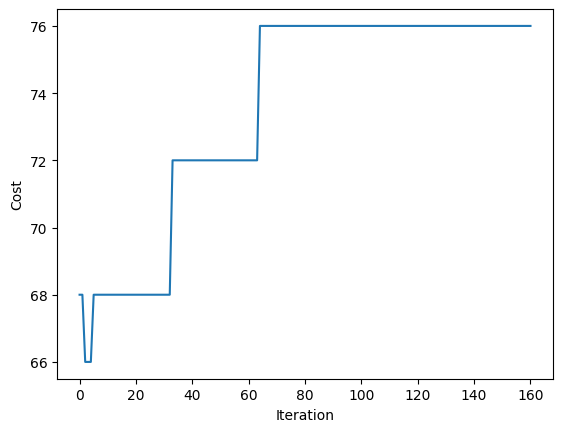

Gate count: 94
Gate count critical path: 80


In [16]:
# run the pass
pm = PassManager()
# need some basic unroll and layout
pm.append([Unroller(["u", "cx"]), TrivialLayout(coupling), ApplyLayout()])
pm.append(VirtualSwap(coupling, visualize=True))
pm.append(OptimizeSwapBeforeMeasure())

# XXX use the PR version once merged into Qiskit
pm.append([RootiSwapWeylDecomposition(), CountOpsLongestPath()])

# set debug logging
import logging

# logger = logging.getLogger("VSWAP")
# logger.setLevel(logging.INFO)

new_circ = pm.run(qc)

print(f"Gate count: {new_circ.count_ops()['riswap']}")
print(
    f"Gate count critical path: {pm.property_set['count_ops_longest_path']['riswap']}"
)

In [19]:
# set up some simple loop to mess with cooling rate, find a rate that makes it actually converge to a minima
# range of cooling_rates between .1 and .001, log scale
cooling_rate_list = np.logspace(-3, -1, 5)
scores = []
for cooling_rate in cooling_rate_list:
    print(f"Cooling rate: {cooling_rate}")
    pm = PassManager()
    # need some basic unroll and layout
    pm.append([Unroller(["u", "cx"]), TrivialLayout(coupling), ApplyLayout()])
    pm.append(VirtualSwap(coupling, sa_params=(5, cooling_rate, 1)))
    pm.append(OptimizeSwapBeforeMeasure())
    pm.append([RootiSwapWeylDecomposition(), CountOpsLongestPath()])
    new_circ = pm.run(qc)

    print(f"Gate count: {new_circ.count_ops()['riswap']}")
    print(
        f"Gate count critical path: {pm.property_set['count_ops_longest_path']['riswap']}"
    )
    scores.append(pm.property_set["scores"])

Cooling rate: 0.001


In [ ]:
import matplotlib.pyplot as plt

for score, cooling_rate in zip(scores, cooling_rate_list):
    plt.plot(score, "-o", label=f"cooling rate: {cooling_rate}")

In [6]:
# run the pass
pm = PassManager()
# need some basic unroll and layout
routing_pass = VirtualSwap(coupling_map=coupling)
pm.append(
    [
        Unroller(["u", "cx"]),
        SabreLayout(coupling_map=coupling, routing_pass=routing_pass),
        ApplyLayout(),
    ]
)
pm.append(routing_pass)
pm.append(OptimizeSwapBeforeMeasure())

# XXX use the PR version once merged into Qiskit
pm.append(RootiSwapWeylDecomposition())
# set debug logging
import logging

logging.basicConfig(level=logging.INFO)
new_circ = pm.run(qc)
# new_circ.draw(output="mpl")
print(f"Gate count: {new_circ.count_ops()['riswap']}")
print(f"Depth: {new_circ.depth()}")

KeyboardInterrupt: 